# Orthophoto Processing with WMS Services

This notebook aims to access the most up-to-date orthophoto (year 2024) of the Basque Country through a WMS (Web Map Service), process the image to match the required spatial resolution, and generate a single RGB raster for the study area.

The workflow is divided into the following main steps:

1. **Dividing the study area into tiles**: The study area is divided into smaller tiles with a specified resolution and size. This step ensures efficient data handling and processing by breaking the larger area into manageable fragments.

2. **Connecting to the WMS and downloading tiles**: A connection to the WMS service is established to retrieve the orthophoto for the specified tiles. Each tile is downloaded as an RGB image in GeoTIFF format, preserving visual quality and geospatial metadata.

3. **Creating the final raster**: The downloaded tiles are merged to produce a single RGB raster that covers the entire extent of the study area. The final raster maintains the desired spatial resolution and is ready for subsequent analysis.

This approach ensures efficient geospatial data processing while maintaining the quality and precision required for geographic analysis.

## 1. Read in the geojson file and split the study area in smaller tiles

In [6]:
# Import libraries
from owslib.wms import WebMapService
import parameters
import geopandas as gpd
import rasterio
from rasterio.crs import CRS
import os
from rasterio.transform import from_bounds
import numpy as np
import matplotlib.pyplot as plt
import math
from rasterio.io import MemoryFile
from rasterio.merge import merge
import contextily as ctx

In [7]:
# Create output folder (if not created yet)
if not os.path.exists(parameters.output_dir):
    os.makedirs(parameters.output_dir)

In [8]:
# Read the file as a geodataframe
polygon = gpd.read_file(parameters.input_file)

In [9]:
# Bounding boxes of the polygon
minx, miny, maxx, maxy = polygon.total_bounds

bbox = (minx, miny, maxx, maxy)

In the following visualization, the polygon representing the study area will be displayed over an OpenStreetMap (OSM) basemap. This allows for a clear understanding of the extent and location of the area of interest. The polygon is kept in its original CRS (EPSG:25830), and the basemap has been adjusted accordingly to ensure proper alignment. The axis labels have been removed to avoid clutter and improve readability.

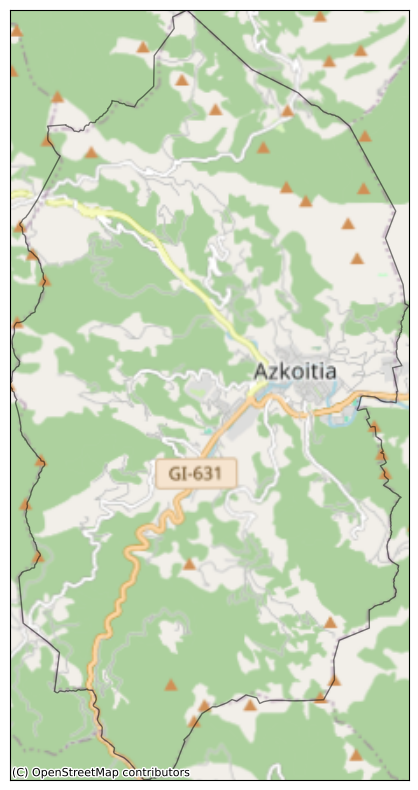

In [10]:
# Figure
fig, ax = plt.subplots(figsize=(10, 10))

# Plot the polygon
polygon.plot(ax=ax, alpha=0.5, edgecolor="black", facecolor="none")

# OSM mapabase with EPSG:25830
ctx.add_basemap(ax, crs=polygon.crs, source=ctx.providers.OpenStreetMap.Mapnik, zoom=12)

# Plot limits
ax.set_xlim(minx, maxx)
ax.set_ylim(miny, maxy)

# Axis labels
ax.set_xticks([])
ax.set_yticks([])

plt.show()

In the following cell, we define the spatial resolution as **2 meters** and set the maximum download size to **16,000 pixels** (4,000 x 4,000). These parameters are carefully chosen to balance analytical precision and service efficiency:

* **Spatial Resolution (2 meters)**: This resolution provides a sufficient level of detail for performing tasks such as change detection analysis, which is commonly applied to orthophotos or satellite imagery. It ensures that fine-scale changes can be identified while keeping computational requirements manageable.

* **Maximum Download Size (4,000 x 4,000 pixels)**: Limiting the download size to a maximum of 16,000 pixels helps prevent overloading the service provider. Larger pixel dimensions may lead to service saturation, slower responses, or even failed requests, especially when handling high-resolution data.

These values are optimized to ensure both effective analysis and efficient interaction with the data service.

In [11]:
# Spatial resolution
spatial_resolution = 2

# Maximun width and height
max_size = 4000

Given the spatial resolution and maximum download size described above, the study area will be divided into smaller tiles. This approach ensures that:

* **Data Integrity is Maintained**: By splitting the study area into manageable tiles, we can work with high-resolution data (2-meter resolution) without exceeding the maximum download size of 16,000 pixels.

* **Service Efficiency is Ensured**: Dividing the area reduces the risk of overwhelming the service provider, allowing for smooth and uninterrupted data retrieval.

This tiling strategy is essential for handling large study areas while adhering to the defined resolution and download constraints.

In [12]:
# Split bbox in smaller tiles
def split_bbox(bbox, resolution, max_size):
    # How many tiles we need with the resolution and sizes provided
    width_total = bbox[2] - bbox[0]
    height_total = bbox[3] - bbox[1]

    num_tiles_x = math.ceil(width_total / (max_size * resolution))
    num_tiles_y = math.ceil(height_total / (max_size * resolution))

    # Bbox for each tile
    tiles = []
    tile_width = width_total / num_tiles_x
    tile_height = height_total / num_tiles_y

    for i in range(num_tiles_x):
        for j in range(num_tiles_y):
            minx = bbox[0] + i * tile_width
            maxx = minx + tile_width
            miny = bbox[1] + j * tile_height
            maxy = miny + tile_height
            tiles.append((minx, miny, maxx, maxy))

    return tiles

In [13]:
# Run the function
tiles = split_bbox(bbox, spatial_resolution, max_size)

# Check the new bounding boxes
tiles

[(551406.3437000001, 4774340.409, 557746.7466000002, 4780465.103),
 (551406.3437000001, 4780465.103, 557746.7466000002, 4786589.797)]

We see that with the parameters provided the polygon has been split in two smaller tiles.

## 2. WMS connection and tiles download

With the bounding boxes for the study area now defined, the next step is to establish a connection to the Web Map Service (WMS) and begin downloading the tiles. Each tile will be retrieved using the previously defined resolution (2 meters) and maximum size (4,000 x 4,000 pixels).

In [14]:
# WMS connection
wms = WebMapService(parameters.wms_url, version='1.3.0')

In [15]:
# Identifier and title for each layer in the service
for layer_id, layer_info in wms.contents.items():
    print(f"Identifier {layer_id}, Title: {layer_info.title}")

Identifier ORTO_EGUNERATUENA_MAS_ACTUALIZADA, Title: ORTO_EGUNERATUENA_MAS_ACTUALIZADA
Identifier ORTO_2023, Title: ORTO_2023
Identifier ORTO_2023_IrRG, Title: ORTO_2023_IrRG
Identifier ORTO_2022, Title: ORTO_2022
Identifier ORTO_2022_IrRG, Title: ORTO_2022_IrRG
Identifier ORTO_2021_IrRG, Title: ORTO_2021_IrRG
Identifier ORTO_2021, Title: ORTO_2021
Identifier ORTO_2020_IrRG, Title: ORTO_2020_IrRG
Identifier ORTO_2020, Title: ORTO_2020
Identifier ORTO_2019_COSTA, Title: ORTO_2019_COSTA
Identifier ORTO_2019_COSTA_IrRG, Title: ORTO_2019_COSTA_IrRG
Identifier ORTO_2019_IrRG, Title: ORTO_2019_IrRG
Identifier ORTO_2019, Title: ORTO_2019
Identifier ORTO_2018_IrRG, Title: ORTO_2018_IrRG
Identifier ORTO_2018, Title: ORTO_2018
Identifier ORTO_2017_IrRG, Title: ORTO_2017_IrRG
Identifier ORTO_2017, Title: ORTO_2017
Identifier ORTO_URBANA_2017, Title: ORTO_URBANA_2017
Identifier ORTO_2016_IrRG, Title: ORTO_2016_IrRG
Identifier ORTO_2016, Title: ORTO_2016
Identifier ORTO_2015_IrRG, Title: ORTO_2015_

From all the available layers accessible through the WMS service, the first layer will be selected for further analysis. This layer represents the most up-to-date orthophoto, which provides the highest temporal accuracy for the study area.

In [16]:
# Making the request for each tile and save the result as a geotiff
def download_tile(bbox, width, height, tile_id):
    # Request
    response = wms.getmap(
        layers=['ORTO_EGUNERATUENA_MAS_ACTUALIZADA'],
        bbox=bbox,
        srs='EPSG:25830',
        size=(width, height),
        format='image/geotiff',
        transparent=True
    )

    # Create tiles folder
    if not os.path.exists(parameters.tiles_dir):
        os.makedirs(parameters.tiles_dir)
    
    # Using MemoryFile and rasterio to create new rasters
    with MemoryFile(response.read()) as memfile:
        with memfile.open() as src:
            # Read the raster information
            data = src.read()

            # Spatial transformation between pixels and the coordinate system
            transform = from_bounds(bbox[0], bbox[1], bbox[2], bbox[3], width, height)
            
            # Output file name
            filename = f'tile_{tile_id}.tif'
            
            # Save the file with all the metadata
            with rasterio.open(
                os.path.join(parameters.tiles_dir, filename), 'w',
                driver='GTiff',
                height=src.height,
                width=src.width,
                count=src.count,
                dtype=src.dtypes[0],
                crs='EPSG:25830',
                transform=transform
            ) as dst:
                dst.write(data)
    
    return os.path.join(parameters.tiles_dir, filename)

In [30]:
# Empty list to store all tile paths
tile_paths = []

In [31]:
# Calculate the size for each tile and download
for idx, tile_bbox in enumerate(tiles):
    width_tile = int((tile_bbox[2] - tile_bbox[0]) / spatial_resolution)
    height_tile = int((tile_bbox[3] - tile_bbox[1]) / spatial_resolution)
    image_filename = download_tile(tile_bbox, width_tile, height_tile, idx)
    tile_paths.append(image_filename)

c:\Users\User\miniconda3\envs\gis\Lib\site-packages\rasterio\io.py:138: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  return DatasetReader(mempath, driver=driver, sharing=sharing, **kwargs)


After dividing the study area into smaller tiles, all the generated tiles that collectively cover the entire region of interest will now be visualized. Each one corresponds to a specific portion of the study area, ensuring that the data remains manageable while maintaining the spatial resolution and size constraints previously defined.

This visualization step provides an overview of the complete dataset, allowing for verification of spatial coverage and data integrity before proceeding with further analysis.

In [32]:
# Function to visualize RGB GeoTIFF tiles
def plot_rgb_tiles(tile_paths):
    fig, axes = plt.subplots(1, len(tile_paths), figsize=(15, 8))
    # Handle single tile case
    if len(tile_paths) == 1:  
        axes = [axes]

    for ax, tile_path in zip(axes, tile_paths):
        with rasterio.open(tile_path) as src:
            # Read RGB bands
            r = src.read(1)  # Red band
            g = src.read(2)  # Green band
            b = src.read(3)  # Blue band
            # Combine into an RGB image
            rgb = np.stack((r, g, b), axis=-1)  
            transform = src.transform

        # Plot the tile as an RGB image
        ax.imshow(rgb)
        ax.set_title(f"Tile: {os.path.basename(tile_path)}")
        ax.set_xlabel("Easting")
        ax.set_ylabel("Northing")
    
    plt.tight_layout()
    plt.show()

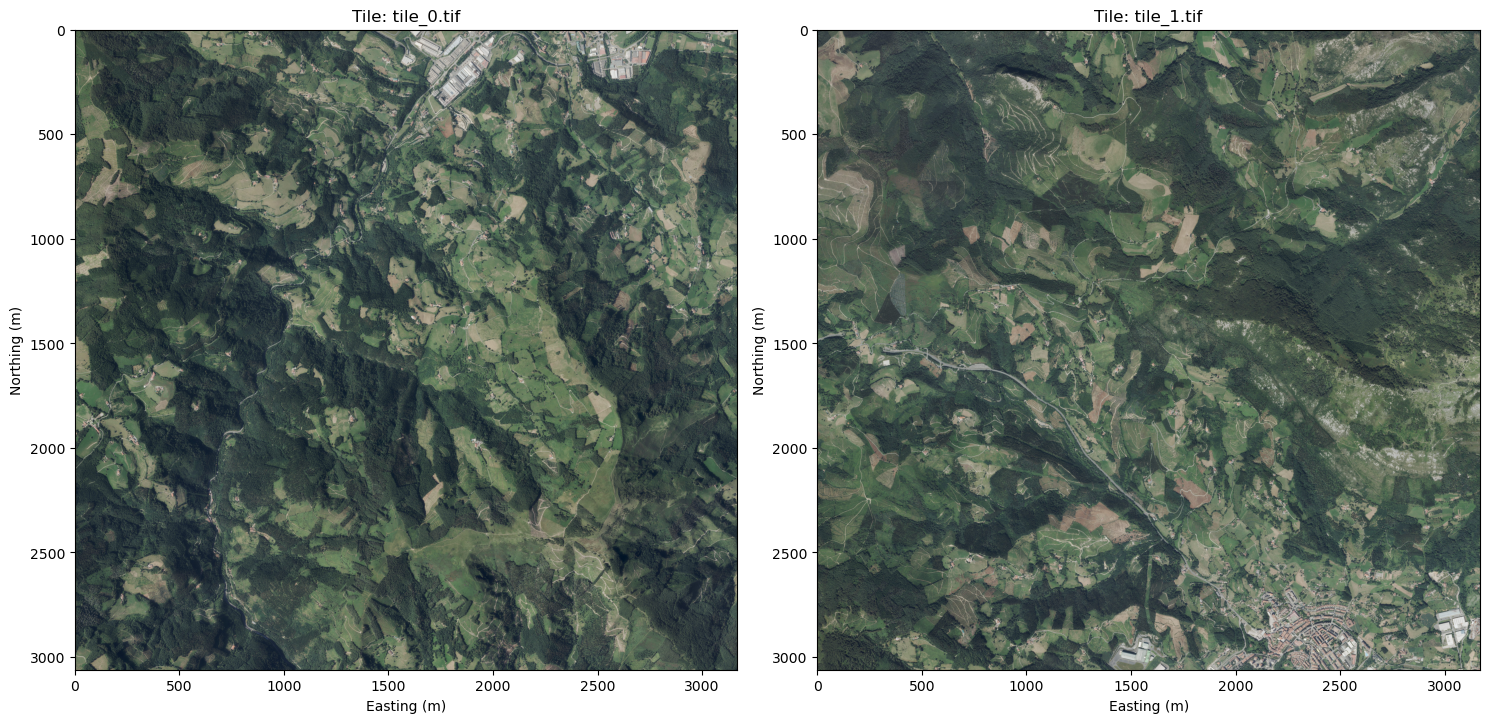

In [33]:
# Visualize the RGB tiles
plot_rgb_tiles(tile_paths)

## 3. Merging the tiles

Now that all the tiles have been created and visualized, the next step is to merge them into a single file. Combining the tiles into a single raster file has several advantages:

* **Simplified Data Management**: Working with a single file instead of multiple tiles makes the data easier to handle and reduces the complexity of file operations.
* **Seamless Analysis**: Some geospatial analyses require continuous raster data without the boundaries or overlaps of individual tiles.
* **Improved Visualization**: A single file ensures smooth visualization of the entire study area without interruptions caused by tile edges.
* **Compatibility with Tools**: Many GIS tools and workflows are optimized for processing unified raster datasets rather than multiple smaller tiles.

This process will produce a single GeoTIFF file that represents the entire study area, maintaining the spatial resolution and extent of the original tiles.

In [34]:
# Merge tiles in one raster
def merge_images(tile_paths):
    # Read each tile
    src_files_to_mosaic = []
    for img in tile_paths:
        src = rasterio.open(img)
        src_files_to_mosaic.append(src)

    # Merge
    mosaic, out_trans = merge(src_files_to_mosaic)

    # Output raster metadata
    out_meta = src_files_to_mosaic[0].meta.copy()
    out_meta.update({
        "driver": "GTiff",
        "height": mosaic.shape[1],
        "width": mosaic.shape[2],
        "transform": out_trans
    })

    # Store as a geotiff moduan gorde
    with rasterio.open(os.path.join(parameters.tiles_dir, 'merged.tif'), 'w', **out_meta) as dest:
        dest.write(mosaic)

In [35]:
# Create the raster
merge_images(tile_paths)

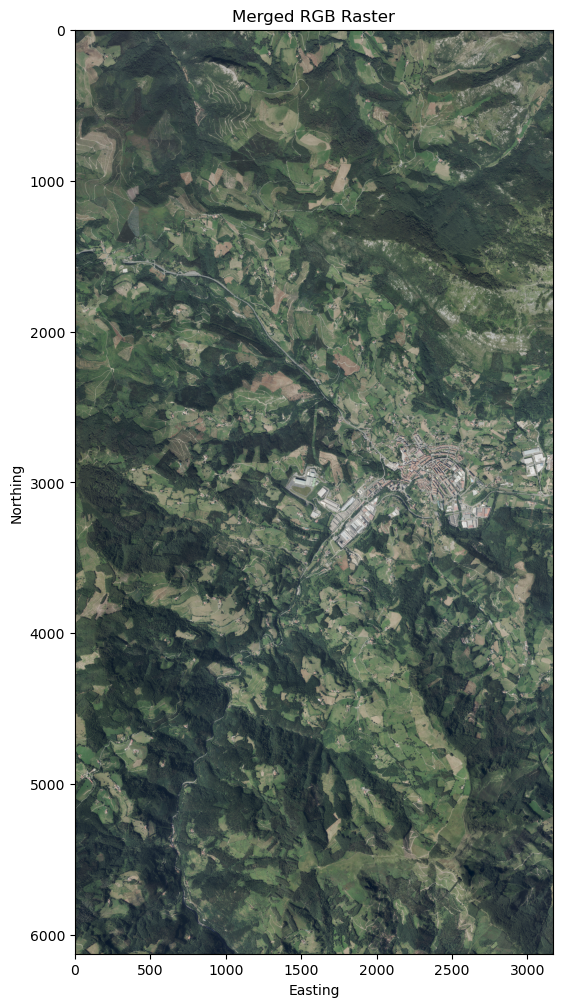

In [39]:
# Path to the merged raster
merged_raster_path = os.path.join(parameters.tiles_dir, 'merged.tif')

# Open the merged raster
with rasterio.open(merged_raster_path) as src:
    # Read RGB bands (assuming the raster has 3 bands: R, G, B)
    r = src.read(1)  # Red band
    g = src.read(2)  # Green band
    b = src.read(3)  # Blue band
    rgb = np.stack((r, g, b), axis=-1)  # Combine into an RGB image
    transform = src.transform  # Transformation for spatial reference

# Configure the visualization
plt.figure(figsize=(15, 12))
plt.title("Merged RGB Raster")
plt.imshow(rgb)
plt.xlabel("Easting")
plt.ylabel("Northing")
plt.show()

To conclude the project, the RGB image stored in the ```merged.tif``` file, which represents the entire study area, will be visualized directly in the notebook. This image combines all the individual tiles into a seamless raster, allowing for a comprehensive view of the region.

This step is essential for verifying the quality and spatial continuity of the merged data, ensuring that it accurately represents the study area and is ready for any subsequent analyses or presentations.